# PHYS555 - Machine Learning Project - Q2
Karlee Zammit - V00823093

## Use 'sklearn.svm.SVC' to classify your data. Then, compare results (taken from different metrics such as confusion matrices, accuracy, recall and precision, recall and AUC) with the best results obtained from an ANN model and discuss the comparisons.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter  
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from scipy import interp
import scikitplot as skplt
from sklearn.multiclass import OneVsRestClassifier
import seaborn as sns

# Functions

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.viridis):
    
    #cmap=plt.cm.Blues
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Load in Data and Balance Via Undersampling

In [3]:
# Load in data and print out a few rows, as well as the shape of the data
df = pd.read_csv('covtype.csv')
print(df.shape)
df.head()

(581012, 55)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [4]:
# This one takes forever... might not be appropriate for this dataset, unless I can save it once it's done 
#cnn = CondensedNearestNeighbour(n_neighbors=3, sampling_strategy='auto', random_state=42)
X = df.drop(["Cover_Type"], axis=1).values
y = df["Cover_Type"].values
print('Original dataset shape %s' % Counter(y))  
#X_res, y_res = cnn.fit_resample(X, y)
#print('Resampled dataset shape %s' % Counter(y_res))  

Original dataset shape Counter({2: 283301, 1: 211840, 3: 35754, 7: 20510, 6: 17367, 5: 9493, 4: 2747})


In [5]:
# This might be better because it's such a huge dataset
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))
print(X_res.shape)
print(y_res.shape)

Resampled dataset shape Counter({1: 2747, 2: 2747, 3: 2747, 4: 2747, 5: 2747, 6: 2747, 7: 2747})
(19229, 54)
(19229,)


In [6]:
ohe = OneHotEncoder(sparse=False)
tar= np.reshape(y_res,(-1,1))
tar = ohe.fit_transform(tar)

X_tr, X_va, Y_tr, Y_va = train_test_split(X_res, tar, test_size=0.25)
print ('training set == ',np.shape(X_tr),np.shape(Y_tr),',, validation set == ', np.shape(X_va),np.shape(Y_va))

# Normalize the data, as was done in Q2
scaler_S= StandardScaler().fit(X_tr)  # line #2
X_tr_Norm= scaler_S.transform(X_tr) # line # 3
X_va_Norm= scaler_S.transform(X_va)  # Line #4

training set ==  (14421, 54) (14421, 7) ,, validation set ==  (4808, 54) (4808, 7)


# Data Visualization

array([[<AxesSubplot:title={'center':'Elevation'}>,
        <AxesSubplot:title={'center':'Aspect'}>,
        <AxesSubplot:title={'center':'Slope'}>],
       [<AxesSubplot:title={'center':'Horizontal_Distance_To_Hydrology'}>,
        <AxesSubplot:title={'center':'Vertical_Distance_To_Hydrology'}>,
        <AxesSubplot:title={'center':'Horizontal_Distance_To_Roadways'}>],
       [<AxesSubplot:title={'center':'Hillshade_9am'}>,
        <AxesSubplot:title={'center':'Hillshade_Noon'}>,
        <AxesSubplot:title={'center':'Hillshade_3pm'}>],
       [<AxesSubplot:title={'center':'Horizontal_Distance_To_Fire_Points'}>,
        <AxesSubplot:title={'center':'Cover_Type'}>, <AxesSubplot:>]],
      dtype=object)

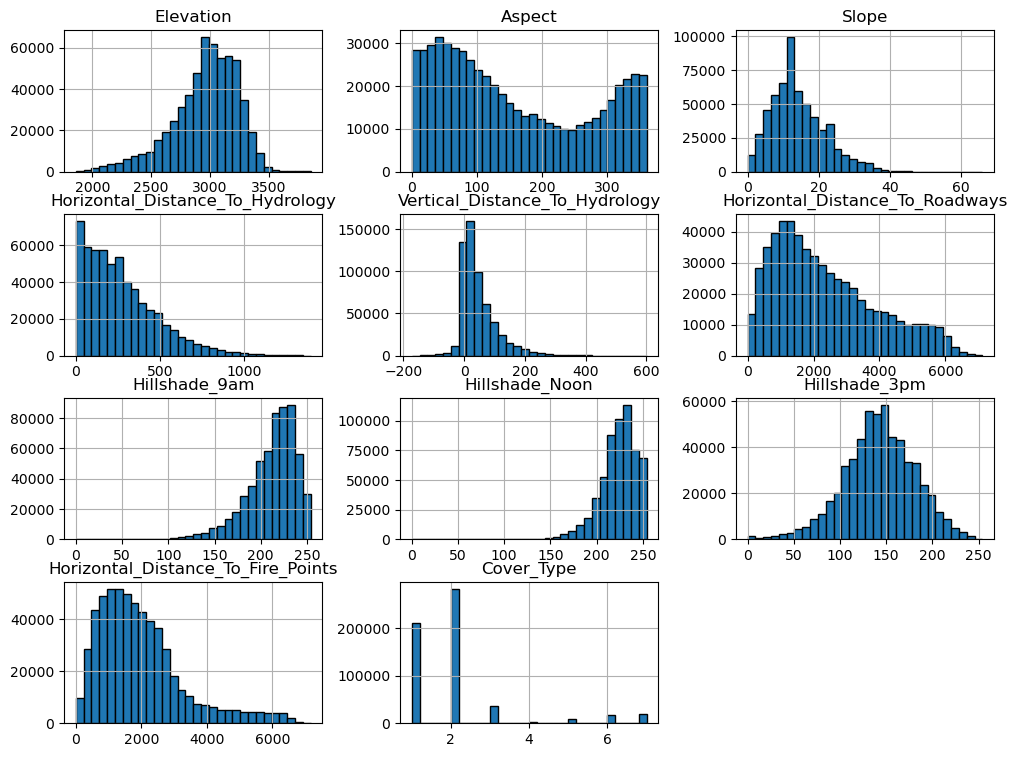

In [7]:
# Plot a histogram of the continuous variables, and the target variable
df_cont = df.drop(['Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40'], axis=1)

df_cont.hist(figsize=(12, 9), bins=30, edgecolor="black")

In [41]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.hist(X_tr[:,0])
ax1.title('Training, Not Normalized')
ax2.hist(X_va[:,0])
ax2.title('Validation, Not Normalized')
ax3.hist(X_tr_Norm[:,0])
ax3.title('Training, Normalized')
ax4.hist(X_va_Norm[:,0]
plt.title('Validation, Normalized')

SyntaxError: invalid syntax (3710357562.py, line 9)

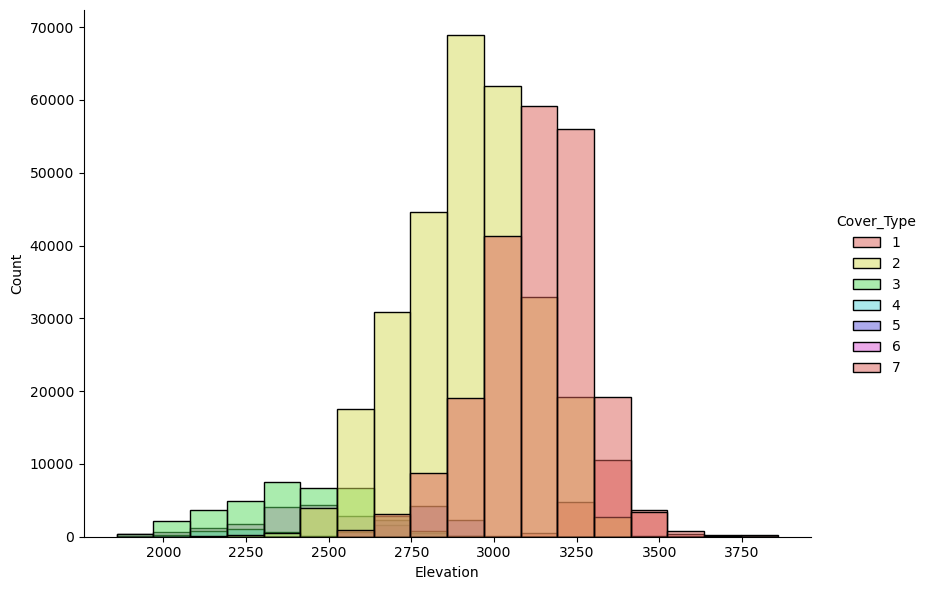

In [44]:
sns.displot(data=df, x='Elevation', bins=18,
            height=6, aspect=1.4, hue='Cover_Type',
            palette='hls')

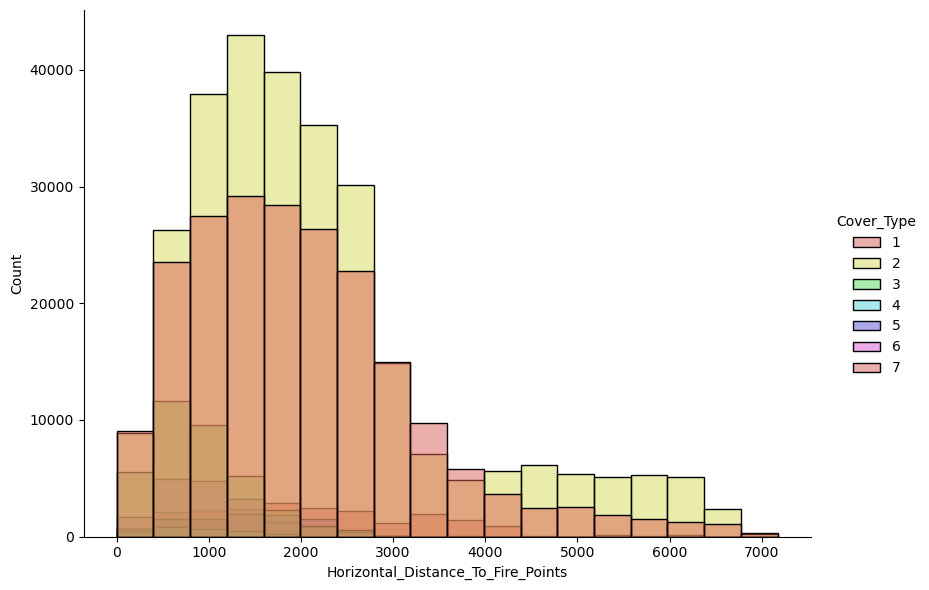

In [43]:
sns.displot(data=df, x='Horizontal_Distance_To_Fire_Points', bins=18,
            height=6, aspect=1.4, hue='Cover_Type',
            palette='hls')
#GnBu

In [ ]:
# plot t-sne
# maybe k mean clustering?
# plot PCA and explain why not using that

# ANN

In [10]:
#ann_pipeline = Pipeline([('ANNcls', MLPClassifier(early_stopping=True, n_iter_no_change=5, max_iter=500,
#                                                  learning_rate='adaptive', solver='sgd', validation_fraction=0.1))])
            
#params = [{'ANNcls__activation':['relu', 'tanh'], 'ANNcls__hidden_layer_sizes':[(20,50,20)]}]

#gs_ann = GridSearchCV(ann_pipeline,
#                      param_grid=params,
#                      scoring='accuracy',
#                      cv=10)

#gs_ann.fit(X_tr_Norm, Y_tr)
#.argmax(axis=1)

#gs_ann.best_params_

Results of first pipeline (with a set hidden layer) (commenting out so faster run times in the future):

<div>
<img src="ANN-result-forest.png" width="300"/>
</div>

Result of second pipeline:

{'ANNcls__activation': 'relu', 'ANNcls__hidden_layer_sizes': (20, 50, 20)}

And this performs better than the last option so switching to this.

Weird, I did it again, 20, 50, 20 is better than 20, 50, 50, and it switched back to tanh. Running it again to be sure, but only with 20, 50, 20. 

Now it says relu. I'm going to stick with relu. 

In [11]:
clf_ANN = MLPClassifier(solver='adam', activation='relu', hidden_layer_sizes=(20,50,20), 
                        max_iter=500, early_stopping=True, n_iter_no_change=5, 
                        validation_fraction=0.1, learning_rate='adaptive',random_state=42)

## fitting the model:
clf_ANN.fit(X_tr_Norm, Y_tr)

## predict the response for tr and va sets. We can have two outputs: probability (e.g.,PY_tr_prob ) and  the winner class (e.g.,PY_tr):
ANN_tr_prob = clf_ANN.predict_proba(X_tr_Norm)
ANN_tr_pred = clf_ANN.predict(X_tr_Norm)

ANN_va_prob = clf_ANN.predict_proba(X_va_Norm)
ANN_va_pred = clf_ANN.predict(X_va_Norm)

Normalized confusion matrix


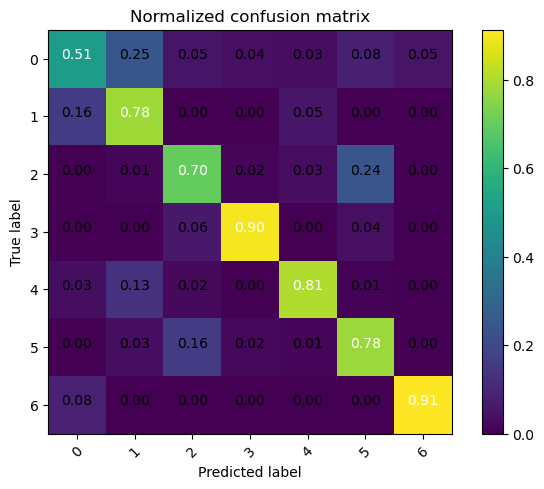

In [12]:
cnf_matrix_ANN = confusion_matrix(ANN_va_pred.argmax(axis=1), Y_va.argmax(axis=1))
plt.figure()
plot_confusion_matrix(cnf_matrix_ANN, classes=['0','1', '2', '3', '4', '5', '6'], normalize=True,
                      title='Normalized confusion matrix')

In [13]:
grid_predictions = clf_ANN.predict(X_va_Norm)
print(classification_report(Y_va.argmax(axis=1), grid_predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.51      0.81      0.62       717
           1       0.78      0.39      0.52       668
           2       0.70      0.69      0.69       664
           3       0.90      0.90      0.90       655
           4       0.81      0.88      0.84       678
           5       0.78      0.60      0.68       711
           6       0.91      0.92      0.92       715

    accuracy                           0.74      4808
   macro avg       0.77      0.74      0.74      4808
weighted avg       0.77      0.74      0.74      4808



In [14]:
#roc_multiclass(ANN_va_pred, Y_va)

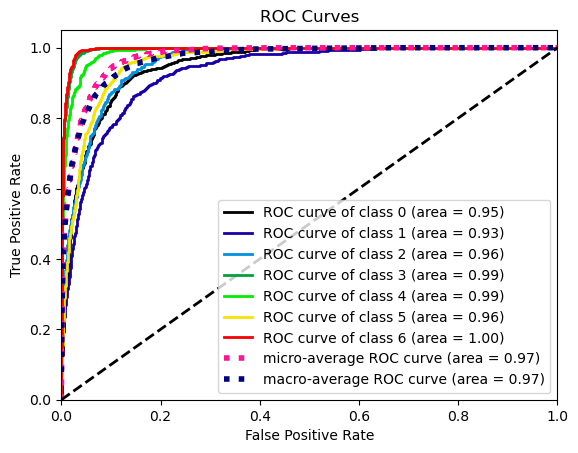

In [15]:
skplt.metrics.plot_roc(Y_va.argmax(axis=1), ANN_va_prob)
plt.show()

In [16]:
# Need to plot detections histograms still 

# Support Vector Machine

Initially, I used a pipeline to determine the best parameters for the SVM classifier. For the sake of time when rerunning, I've commented out the pipeline and initilized in the cell below.

In [17]:
#\sklearn.svm.SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, 
# class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)[source]

#svm_pipeline = Pipeline([('PCA', PCA()), ('svc', SVC(decision_function_shape = 'ovr'))])
            
#params = [{'PCA__n_components':[.7, .9, .999], 'svc__kernel':['linear', 'poly', 'rbf', 'sigmoid'], 'svc__gamma':['scale', 'auto'], 'svc__degree':[2, 3, 4]}]

#gs_svm = GridSearchCV(svm_pipeline,
#                      param_grid=params,
#                      scoring='accuracy',
#                      cv=5)

#gs_svm.fit(X_tr_Norm, Y_tr.argmax(axis=1))

#gs_svm.best_params_

We have now determined that these parameters are best: 
- All components (ie. do not use PCA) - if things take too long, I will come back to this
- The 'rbf' kernel (meaning that the degree variable is not used), nonlinear SVM

In [18]:
# Now I need to determine the best value of C (defaults otherwise, using the rbf kernel)
#svm_pipeline2 = Pipeline([('svc', SVC(decision_function_shape = 'ovr', kernel='rbf'))])

#params = [{'svc__C':[0.1, 1, 10, 100, 1000], 'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001]}]

#gs_svm2 = GridSearchCV(svm_pipeline2,
#                      param_grid=params,
#                      scoring='accuracy',
#                      cv=5)

#gs_svm2.fit(X_tr_Norm, Y_tr.argmax(axis=1))

#gs_svm2.best_params_

#{'svc__C': 100, 'svc__gamma': 0.1}

Results were: {'svc__C': 100, 'svc__gamma': 0.1}

In [19]:
#grid_predictions = gs_svm2.predict(X_va_Norm)
  
# print classification report
#print(classification_report(Y_va.argmax(axis=1), grid_predictions))

<div>
<img src="results.png" width="400"/>
</div>

In [20]:
clf_svm = SVC(decision_function_shape='ovr', kernel='rbf', gamma=0.1, C=100, probability=True, break_ties=True)
clf_svm.fit(X_tr_Norm, Y_tr.argmax(axis=1))

SVC(C=100, break_ties=True, gamma=0.1, probability=True)

In [21]:
# Using those parameters, determine the training and validation predictions
SVM_tr_prob = clf_svm.predict_proba(X_tr_Norm)
SVM_tr_pred = clf_svm.predict(X_tr_Norm)

SVM_va_prob = clf_svm.predict_proba(X_va_Norm)
SVM_va_pred = clf_svm.predict(X_va_Norm)

In [26]:
print(SVM_va_pred.shape)
print(Y_va.shape)

(4808,)
(4808, 7)


Normalized confusion matrix


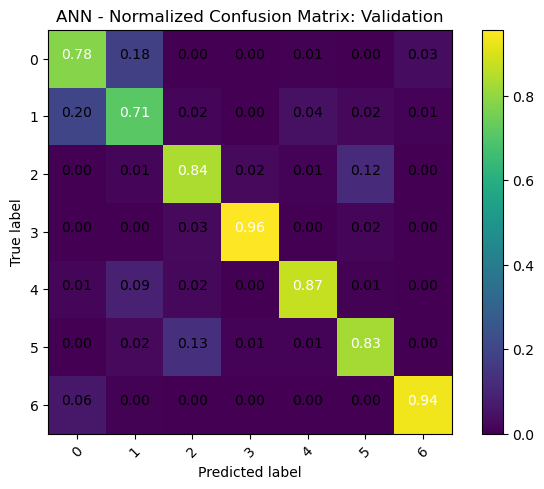

In [27]:
cnf_matrix = confusion_matrix(SVM_va_pred, Y_va.argmax(axis=1))
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1', '2', '3', '4', '5', '6'], normalize=True,
                      title='SVM - Normalized Confusion Matrix: Validation')

In [28]:
grid_predictions = clf_svm.predict(X_va_Norm)
print(classification_report(Y_va.argmax(axis=1), grid_predictions))

              precision    recall  f1-score   support

           0       0.78      0.75      0.76       717
           1       0.71      0.68      0.69       668
           2       0.84      0.79      0.81       664
           3       0.96      0.97      0.96       655
           4       0.87      0.93      0.90       678
           5       0.83      0.86      0.84       711
           6       0.94      0.96      0.95       715

    accuracy                           0.85      4808
   macro avg       0.85      0.85      0.85      4808
weighted avg       0.85      0.85      0.85      4808



In [34]:
y_score = clf_svm.fit(X_tr_Norm, Y_tr.argmax(axis=1)).decision_function(X_va_Norm)

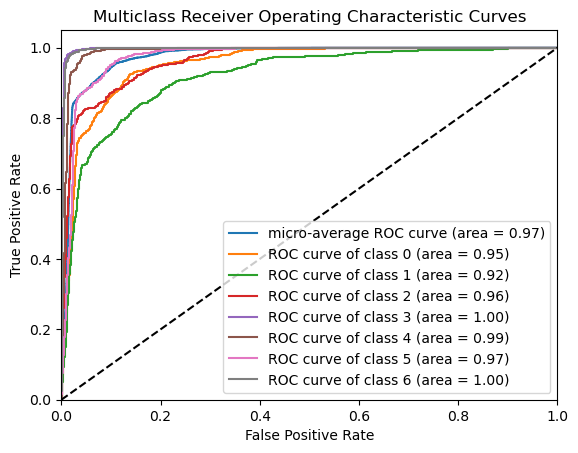

In [35]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(Y_va[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_va.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(7):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass Receiver Operating Characteristic Curves')
plt.legend(loc="lower right")
plt.show()

### IDK Why this is different but need to move on

In [ ]:
# Learn to predict each class against the other
classifier = OneVsRestClassifier(SVC(kernel='rbf', gamma=0.1, C=100, probability=True, break_ties=True,
                                 random_state=42))
y_score = classifier.fit(X_tr_Norm, Y_tr).decision_function(X_va_Norm)

In [30]:
grid_predictions2 = classifier.predict(X_va_Norm)
print(classification_report(Y_va, grid_predictions2))

              precision    recall  f1-score   support

           0       0.79      0.74      0.76       717
           1       0.72      0.65      0.68       668
           2       0.84      0.77      0.80       664
           3       0.95      0.95      0.95       655
           4       0.88      0.93      0.90       678
           5       0.82      0.83      0.83       711
           6       0.94      0.96      0.95       715

   micro avg       0.85      0.83      0.84      4808
   macro avg       0.85      0.83      0.84      4808
weighted avg       0.85      0.83      0.84      4808
 samples avg       0.82      0.83      0.82      4808



C:\Users\Karlee\miniconda3\envs\phys555\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# References 

**Forest Cover Dataset:**
https://www.kaggle.com/datasets/uciml/forest-cover-type-dataset

https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [ ]:
https://www.projectpro.io/recipes/compare-sklearn-classification-algorithms-in-python